## Basic Bayesian Neural Network with Pytorch

We will walk through an implementation of a very basic BNN in pytorch and get our first look at uncertainty quantification.

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from torch import optim

### Load the dataset

Since this is just an excersise, and we are more concerned about the implementation of Bayesian Layers with pytorch, lets keep it simple.
We will use the Breast Cancer dataset from Sklearn, and use two features for visualization.

In [9]:
cancer1 = load_breast_cancer()

cancer = pd.DataFrame(cancer1.data, columns=cancer1.feature_names)
cancer.columns = cancer.columns.str.replace(' ','_')

# Add a column for the response variable: malignant or benign
cancer['Target'] = cancer1.target
X = cancer[['mean_radius','mean_texture']].values
Y = cancer[['Target']].values.reshape(-1)

X = scale(X)
X = X.astype('float32')
Y = Y.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

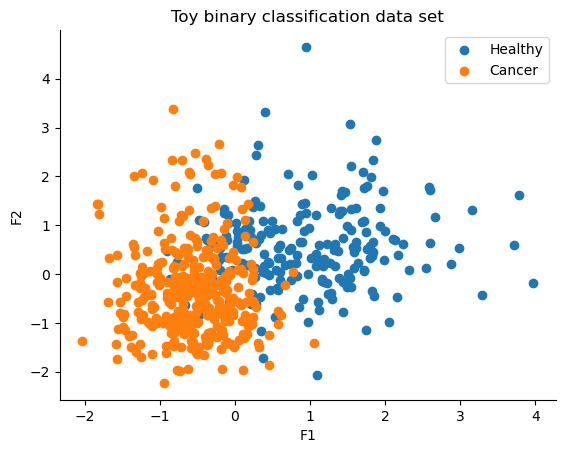

In [10]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="C0", label="Healthy")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="C1", label="Cancer")
sns.despine()
ax.legend()
ax.set(xlabel="F1", ylabel="F2", title="Toy binary classification data set");

### Create our DataLoaders

In [11]:
X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)
X_test_tensor = torch.tensor(X_test)
Y_test_tensor = torch.tensor(Y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Bayesian Layer

In [105]:
# Our Bayesian version of pytorch linear layers.
class BayesianLinear(torch.nn.Module):
    def __init__(self,in_dim,out_dim,bias=False,device='cuda'):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.bias = bias
        self.device = device

        # Initalize our log variance to a small value -> epx(-2).sqrt() ~ 0.36
        # Try playing with these values and see how it effects training
        # BNNs are tricky!
        self.w_log_var = nn.Parameter(-2 + 0.1* torch.randn([self.in_dim,self.out_dim],device=self.device))
        self.w_mu = nn.Parameter(0.1 * torch.randn([self.in_dim,self.out_dim],device=self.device))

        # Same small intialization here
        if self.bias:
            self.bias_log_var = nn.Parameter(-2 + 0.1 * torch.randn(self.out_dim,device=self.device))
            self.bias_mu = nn.Parameter(0.1 * torch.randn([self.out_dim],device=self.device))


    def forward(self,x):
         # Sample weights from approximate posterior: mean + stddev * random noise - reparam trick
        weight = self.w_mu + self.w_log_var.exp().sqrt() * torch.randn_like(self.w_log_var,device=self.device)
        if self.bias:
            # Sample bias similarly if enabled
            bias = self.bias_mu + self.bias_log_var.exp().sqrt() * torch.randn_like(self.bias_log_var ,device=self.device)
        else:
            # If no bias, use zero bias vector
            bias = torch.zeros(self.out_dim,device=self.device)
            
        # Apply linear transformation using sampled weight and bias
        return F.linear(x, weight.t(), bias)


    def kl_div(self):
            # Compute KL divergence between approximate posterior and standard normal prior for weights
            kl_div_W = 0.5 * torch.sum(-self.w_log_var + self.w_log_var.exp() + self.w_mu**2 - 1)

            if self.bias:
                # Compute KL divergence for bias parameters if enabled
                kl_div_b = 0.5 * torch.sum(-self.bias_log_var + self.bias_log_var.exp() + self.bias_mu**2 - 1)
            else:
                kl_div_b = 0
        
            return kl_div_W + kl_div_b 
            



class BayesianNeuralNetwork(nn.Sequential):
    def __init__(self,in_dim=2,use_bias=False,device='cuda'):
        super().__init__()
        self.device = device
        self.BL1 = BayesianLinear(in_dim,5,bias=use_bias,device=self.device)
        self.BL2 = BayesianLinear(5,5,bias=use_bias,device=self.device)
        self.BL3 = BayesianLinear(5,1,bias=use_bias,device=self.device)
        
        self.activation = nn.Tanh()
        self.output_activation = nn.Sigmoid()


    # Sums KL divergence across all layers
    def kl_div(self,):
        return sum(lyr.kl_div() for lyr in self if hasattr(lyr, "kl_div"))


    def forward(self,x):
        x = self.activation(self.BL1(x))
        x = self.activation(self.BL2(x))
        x = self.BL3(x)
        x = self.output_activation(x)
        return x
        

In [100]:


torch.manual_seed(8)
np.random.seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed(8)

bnn = BayesianNeuralNetwork(use_bias=False)
print(bnn)

device = 'cpu'#torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send model to device
bnn = BayesianNeuralNetwork(device=device)

# Choose optimizer
optimizer = optim.AdamW(bnn.parameters(), lr=1e-4)

# Number of Monte Carlo samples per forward pass
num_mc_samples = 1

# Binary classification loss (cross entropy with sigmoid output)
# ELBO !
def elbo_loss(preds, targets, kl, num_samples, dataset_size, beta=1.0):
    bce = F.binary_cross_entropy(preds, targets, reduction='mean')
    kl_scaled = beta * kl / dataset_size
    return bce + kl_scaled

# Training loop
def train_bnn(model, train_loader, test_loader, epochs=50, beta=1.0):
    dataset_size = len(train_loader.dataset)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)

            # Forward pass
            with torch.set_grad_enabled(True):
                preds = model(x_batch)
                kl = model.kl_div()

            loss = elbo_loss(preds, y_batch, kl, num_samples=1, dataset_size=dataset_size, beta=beta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).view(-1, 1)
                preds = model(x_batch)
                predicted = (preds > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        acc = correct / total
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Test Acc: {acc:.4f}")

# Run training
train_bnn(bnn, train_loader, test_loader,epochs=200)

BayesianNeuralNetwork(
  (BL1): BayesianLinear()
  (BL2): BayesianLinear()
  (BL3): BayesianLinear()
  (activation): Tanh()
  (output_activation): Sigmoid()
)
Epoch 001 | Train Loss: 0.7913 | Test Acc: 0.4632
Epoch 011 | Train Loss: 0.7759 | Test Acc: 0.5614
Epoch 021 | Train Loss: 0.7873 | Test Acc: 0.5088
Epoch 031 | Train Loss: 0.7800 | Test Acc: 0.5158
Epoch 041 | Train Loss: 0.7722 | Test Acc: 0.5544
Epoch 051 | Train Loss: 0.7520 | Test Acc: 0.5509
Epoch 061 | Train Loss: 0.7449 | Test Acc: 0.5754
Epoch 071 | Train Loss: 0.7148 | Test Acc: 0.6561
Epoch 081 | Train Loss: 0.6568 | Test Acc: 0.6982
Epoch 091 | Train Loss: 0.5826 | Test Acc: 0.8526
Epoch 101 | Train Loss: 0.5278 | Test Acc: 0.8772
Epoch 111 | Train Loss: 0.4696 | Test Acc: 0.8912
Epoch 121 | Train Loss: 0.4289 | Test Acc: 0.8842
Epoch 131 | Train Loss: 0.4167 | Test Acc: 0.8702
Epoch 141 | Train Loss: 0.4392 | Test Acc: 0.8807
Epoch 151 | Train Loss: 0.4316 | Test Acc: 0.8702
Epoch 161 | Train Loss: 0.4326 | Test Acc

Accuracy: 0.8842105263157894
ROC AUC: 0.9550067308688


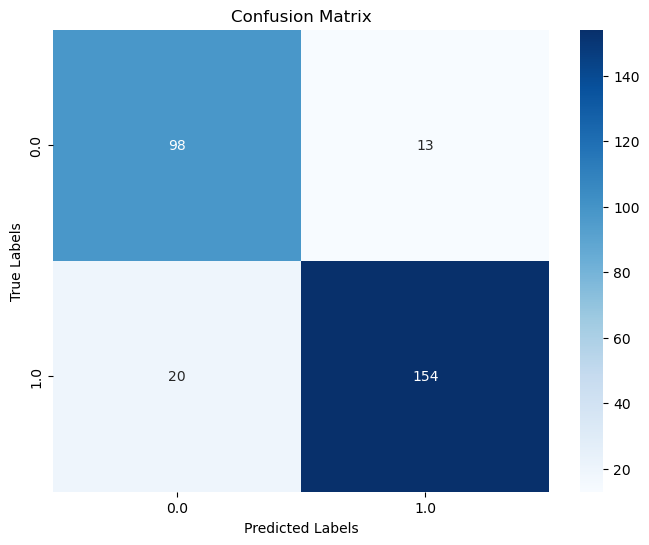

In [101]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_bnn(model, loader, num_mc_samples=10):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).view(-1, 1).float()
            # To obtain the uncertainty profile or final prediction - we sample
            # Meaning we just repeat the same input N_sample times
            # Our final prediction is the mean, and uncertainty is given by standard deviation
            # This is Epistemic uncertainty - we will address aleatoric later.
            preds = torch.stack([model(x) for _ in range(num_mc_samples)]).mean(0)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
    
    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()
    pred_labels = (preds > 0.5).astype(int)
    
    acc = accuracy_score(targets, pred_labels)
    auc = roc_auc_score(targets, preds)
    cm = confusion_matrix(targets, pred_labels)

    print("Accuracy:", acc)
    print("ROC AUC:", auc)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(targets), yticklabels=np.unique(targets))
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()



evaluate_bnn(bnn,test_loader)

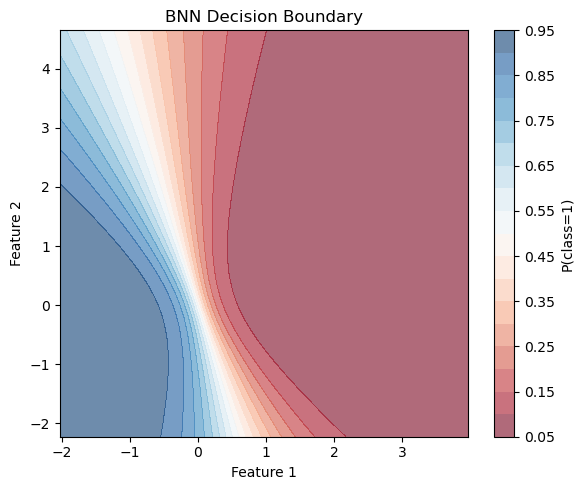

In [102]:

def plot_decision_boundary(model, X, y, num_mc_samples=100, resolution=100):
    model.eval()
    x_min, x_max = X[:,0].min() , X[:,0].max() 
    y_min, y_max = X[:,1].min() , X[:,1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    with torch.no_grad():
        # To obtain the uncertainty profile or final prediction - we sample
        # Meaning we just repeat the same input N_sample times
        # Our final prediction is the mean, and uncertainty is given by standard deviation
        # This is Epistemic uncertainty - we will address aleatoric later.
        preds = torch.stack([model(grid) for _ in range(num_mc_samples)])
        mean_preds = preds.mean(0).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, mean_preds, alpha=0.6, cmap="RdBu", levels=20)
    plt.colorbar(label='P(class=1)')
    plt.title("BNN Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()


plot_decision_boundary(bnn,X,Y)

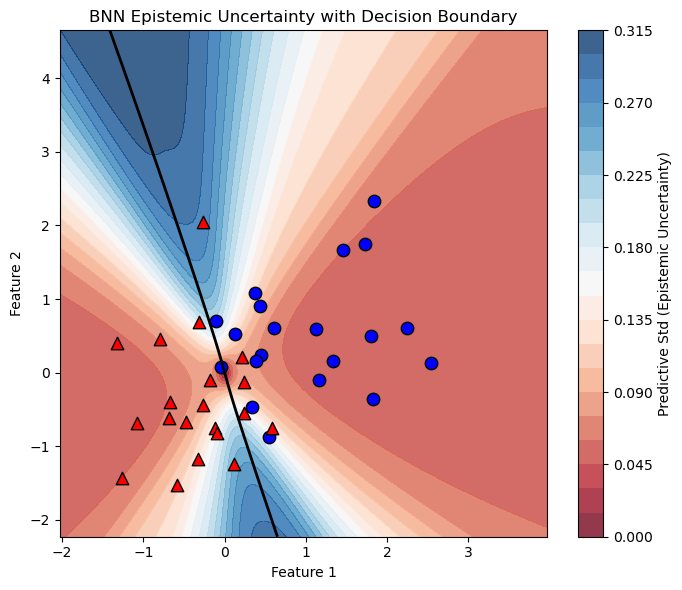

In [103]:
def plot_uncertainty_with_boundary(model, X, y, num_mc_samples=100, resolution=500):
    model.eval()
    x_min, x_max = X[:,0].min() , X[:,0].max() 
    y_min, y_max = X[:,1].min() , X[:,1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    with torch.no_grad():
        # To obtain the uncertainty profile or final prediction - we sample
        # Meaning we just repeat the same input N_sample times
        # Our final prediction is the mean, and uncertainty is given by standard deviation
        # This is Epistemic uncertainty - we will address aleatoric later.
        preds_mc = torch.stack([model(grid) for _ in range(num_mc_samples)])  # [mc, N, 1]
        preds_mean = preds_mc.mean(0).cpu().numpy().reshape(xx.shape)
        std_preds = preds_mc.std(0).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(7,6))
    # Plot uncertainty heatmap
    plt.contourf(xx, yy, std_preds, cmap="RdBu", levels=20, alpha=0.8)
    plt.colorbar(label='Predictive Std (Epistemic Uncertainty)')

    # Overlay decision boundary (mean prediction = 0.5)
    contour = plt.contour(xx, yy, preds_mean, levels=[0.5], colors='black', linewidths=2)

     # Add scatter points from both classes
    X = X.cpu().numpy() if isinstance(X, torch.Tensor) else X
    y = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

    for class_label, marker, color in zip([0, 1], ['o', '^'], ['blue', 'red']):
        idxs = np.where(y == class_label)[0]
        sample_idxs = np.random.choice(idxs, size=min(20, len(idxs)), replace=False)
        plt.scatter(X[sample_idxs, 0], X[sample_idxs, 1], 
                    label=f'Class {class_label}', marker=marker, edgecolor='k', color=color, s=80)
    

    plt.title("BNN Epistemic Uncertainty with Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

plot_uncertainty_with_boundary(bnn,X,Y)

### Uncertainty Evaluation

In the lecture, we discussed how Bayesian Neural Networks (BNNs) improve decision making by incorporating uncertainty estimates (which we will explore in more detail later). However, producing uncertainty estimates is only part of the story — it is crucial to validate whether these uncertainties are meaningful and reliable.

Do the uncertainties produced by the model make sense to you?

In some regions, perhaps yes; in others, maybe not. For example, near the top and bottom edges of the decision boundary, we observe higher epistemic uncertainty, which is expected due to the model’s limited knowledge in those data-sparse regions. However, if the BNN were perfectly calibrated, we would expect the uncertainty to be highest along the entire decision boundary, since that is where class overlap creates inherent ambiguity.

Instead, we see that in the central region, where the classes overlap substantially, the model is overconfident — its uncertainty is lower than it should be. This suggests the model’s uncertainty estimates are not fully capturing the true ambiguity in the data.

Training BNNs is tricky!